# Analysis of Microsoft ML Challenge course videos

We're going to be using the following python packages so make sure you have them installed before you run this notebook.
* pandas
* webvtt
* spacy
* spacy model en_core_web_sm
* textacy
* networkx
* skimage

## Data Ingestion
List the files in the `ytsubs` folder where we downloaded the subtitle files.

In [1]:
import pandas as pd
ytdf = pd.read_pickle('ytdf.pkl')
ytdf[['lesson_id','concept_id']] = ytdf[['lesson_id','concept_id']].astype(int)
ytdf.sort_values(['lesson_id','concept_id','video_url'], inplace=True)

In [2]:
import os
(_, _, filenames) = next(os.walk('ytsubs'))

For each file open the file with the `webvtt-py` python [package](https://pypi.org/project/webvtt-py/) and extract the captions one by one.

Due to a characteristic of these automatically generated subtitle files, some lines are listed more than once in the file. We therefore track the latest line so that we can compare each line to the last one and only import the line if it's different.

Finally we create a pandas dataframe of the results.

In [3]:
import webvtt
captions = []   # list to contain the caption entries
old_line = ''   # last line (to compare with the current line)

for file in filenames:
    for caption in webvtt.read('ytsubs\\' + file):
        
        # get the info elements from the filename
        filename = file.split('.')[0]
        video_title = filename[:-12]
        ytcode = filename[-11:]
        
        for line in caption.lines:
            # ignore lines with <c> codes in them and empty lines
            if ('<c>' not in line) and (len(line.strip()) > 2):
                # add only new lines to the captions list
                if line != old_line:
                    captions.append({
                        'ytcode': ytcode,  # video code
                        'title': video_title,  # video title
                        'text': line,  # caption line
                        'start': caption.start_in_seconds,  # when the line appears
                        'end': caption.end_in_seconds  # when the line disappears
                    })
                    old_line = line
capdf = pd.DataFrame(captions)

We now have the following columns in `capdf`, which contains the subtitle data, and `ytdf`, which contains the video metadata:

In [4]:
print(capdf.shape, capdf.columns)
print(ytdf.shape, ytdf.columns)

(6938, 5) Index(['ytcode', 'title', 'text', 'start', 'end'], dtype='object')
(156, 7) Index(['concept_name', 'concept_url', 'lesson_name', 'lesson_url', 'video_url',
       'lesson_id', 'concept_id'],
      dtype='object')


In [5]:
capdf.sample(5, random_state=42)

ytcode                                          title  \
2252  D8Gw2Cbv2MY        2 15 B 11983 Udacity ML Course FINAL V2   
5338  bif1io4cNQQ  5 02 11983 Udacity ML Course Lesson5 FINAL V2   
2789  msaXELuThsY          2 25 11983 Udacity ML Course FINAL V2   
2678  40iS8bfeFv8          2 23 11983 Udacity ML Course FINAL V2   
6370  UxGSdEHLdUU  6 02 11983 Udacity ML Course Lesson6 FINAL V2   

                                                   text    start      end  
2252  what we call in the language of Azure Machine ...  279.680  282.905  
5338             So what exactly is a training cluster?   53.890   56.820  
2789  Deciding, for example, on the best option to s...   17.235   23.100  
2678  As it turns out, there are several approaches ...   60.145   67.070  
6370  AI system should engage and empower people and...  112.710  116.200

In [6]:
ytdf.sample(5, random_state=42)

concept_name  \
96    8. Walkthrough: Train a Simple Neural Net   
69       3. Supervised Learning: Classification   
82                    21. Unsupervised Learning   
75          14. Supervised Learning: Regression   
112                       20. Anomaly Detection   

                                           concept_url  \
96   https://classroom.udacity.com/nanodegrees/nd00...   
69   https://classroom.udacity.com/nanodegrees/nd00...   
82   https://classroom.udacity.com/nanodegrees/nd00...   
75   https://classroom.udacity.com/nanodegrees/nd00...   
112  https://classroom.udacity.com/nanodegrees/nd00...   

                            lesson_name  \
96     Applications of Machine Learning   
69   Supervised & Unsupervised Learning   
82   Supervised & Unsupervised Learning   
75   Supervised & Unsupervised Learning   
112    Applications of Machine Learning   

                                            lesson_url    video_url  \
96   https://classroom.udacity.com/nanodegrees/nd00...  Tt23S02LP6g   
69   https://classroom.udacity.com/nanodegrees/nd00...  9mbrJjUEyEI   
82   https://classroom.udacity.com/nanodegrees/nd00...  xks3HdxklnE   
75   https://classroom.udacity.com/nanodegrees/nd00...  pf9ccUR8fJg   
112  https://classroom.udacity.com/nanodegrees/nd00...  z0ZtPmBJVYY   

     lesson_id  concept_id  
96           4           8  
69           3           3  
82           3          21  
75           3          14  
112          4          20

## Data Manipulation

We start by merging those two dataframes so that we can match the captions to the lessons. We'll also make sure the rows are sorted in order of lesson, concept and start time (i.e. all in chronological order).

In [7]:
subs = capdf.merge(ytdf, left_on='ytcode', right_on='video_url').sort_values(['lesson_id','concept_id','video_url','start'])
subs.shape

(6938, 12)

The subtitles are in separate lines but we want to parse the text as full documents. To do that, we need to group the rows by video (keeping the lesson ID and lesson name) and use the `join` method to concatenate them.

Using `groupby` returns the metadata as a MultiIndex with an index level for each field: lesson, concept and title. To convert the MultiIndex back to dataframe columns we call `reset_index` on the result.

In [8]:
cols = ['lesson_id','lesson_name']
lesson_text = subs.groupby(cols).text.apply(' '.join).reset_index().sort_values(['lesson_id'])
lesson_text.shape

(8, 3)

## Data Cleaning
### Text analytics preparation
We're going to use [spaCy](https://spacy.io/api) to analyze the text. We need to load the package as well as the language model.

We're going to use the [small model](https://spacy.io/models/en#en_core_web_sm) which is 11MB in size. The main difference between this and the [medium-sized model](https://spacy.io/models/en#en_core_web_md) (48MB) is that the larger model also provides word vectors for each token.

On loading the model there are three parts to the pipeline that get loaded - the part of speech tagger, the dependency parser and the named-entity recognizer. Since we only need the POS tagger, we disable the other parts of the pipeline.

In [9]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser','ner'])

To use spaCy, text can be run through the model either individually using `doc = nlp(text)` but when you have a number of text lines to pass through the model, spaCy has a convenient batch function that is about 30% faster.

Using `nlp.pipe` will return a generator so, to assign that to the dataframe column, we need to force evaluation of all the items by using the `list` constructor.

In [10]:
lesson_text['doc'] = list(nlp.pipe(lesson_text.text))

Running the text through spaCy has automatically tokenized the text, and identified the part of speech tag for each token.

## Data Analysis: Term Frequencies
At the moment, to extract key words, we're going to focus on nouns (`NOUN`), proper nouns (`PROPN`), adjectives (`ADJ`), verbs (`VERB`) and adverbs (`ADV`). We'll use the `Counter` in the built in `collections` class to count the number of each word type.

The words 'machine', 'learning' and 'model' occur significantly in each video so for the word clouds I'm removing them, as well as other stop words in spaCy's default list.

In [11]:
from collections import Counter
tags = ['NOUN','PROPN','ADJ','VERB','ADV']
extra_stop = ['machine','learning','model']
lesson_text['counter'] = ''
for i,lesson in lesson_text.iterrows():
    tokens = [tok.lemma_.lower()
        for tok in lesson.doc
            if tok.pos_ in tags                       # nouns, verbs, etc.
            and not tok.is_stop                       # default stop words
            and tok.lemma_.lower() not in extra_stop  # extra stop words
    ]
    lesson_text.at[i,'counter'] = Counter(tokens)

## Data analysis: Word Clouds
Now that we've calculated the word frequencies we can generate word clouds to show visually how often words are used in the videos

In [12]:
import wordcloud as wc
lesson_text['cloud'] = ''
for i,counter in lesson_text.counter.iteritems():
    cloud = wc.WordCloud()
    lesson_text.at[i,'cloud'] = cloud.generate_from_frequencies(counter)

Let's see what the word clouds look like for each lesson.

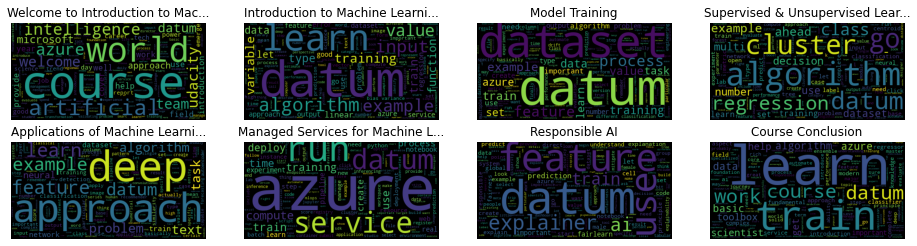

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16,4))
for axi,(_,(lesson,wcloud)) in zip(ax.ravel(), lesson_text[['lesson_name','cloud']].iterrows()):
    axi.imshow(wcloud)
    axi.axis('off')
    axi.set_title(lesson[:30] + ('' if len(lesson)<=30 else '...'))
plt.show()

## Data Analysis: Lesson Graph

Another way to review the lesson concepts is to look at a graph of the lesson concepts.

We define our graph such that:
* each `node` is a keyword in the lesson, and
* two nodes are connected by an `edge` if they occur within 5 words of each other.

The `textacy` package has a number of algorithms that identify keywords in spaCy documents. For this exercise we will use the `sgrank` algorithm. If you're interested in exploring how SGRank works, you can [find the code on github](https://github.com/chartbeat-labs/textacy/blob/master/textacy/ke/sgrank.py).

The `networkx` package helps us build a graph of the keywords

In [14]:
import textacy.ke
import networkx as nx
def make_doc_graph(doc, g_window, sg_topn, sg_window, sg_ngrams):
    '''
    Return a graph of the document keywords with co-ocurring keywords linked
    Parameters:
      doc         spaCy document
      g_window    window used for checking keyword colocation
      sg_topn     top n words for the SGRank algorithm
      sg_window   window size for the SGRank algorithm
      sg_ngrams   tuple of ngram sizes for the SGRank algorithm
    '''
    # identify the key words (also returns respective scores for each word)
    kwds = textacy.ke.sgrank(doc, ngrams=sg_ngrams, topn=sg_topn, window_size=sg_window)
    
    # create a list of the words alone
    kwds_words = [kw[0] for kw in kwds]
    g = nx.Graph()
    
    # for each token in the lesson
    for t1 in doc:
        # get its lemma (base form)
        t1lem = t1.lemma_.lower()
        
        if t1lem in kwds_words:  # if it's a keyword
            # calculate the window size
            minpos = max(0,t1.i-g_window)
            maxpos = min(len(doc),t1.i+g_window)
            
            for t2 in doc[minpos:maxpos]:  # for each token in the window
                t2lem = t2.lemma_.lower()
                
                if t2lem in kwds_words:  # if it's also a keyword, add an edge
                    g.add_edge(t1lem,t2lem)
    return g

To draw the graph, `networkx` provides a number of options. By default, graphs are drawn with large nodes and node labels at the center of the nodes.

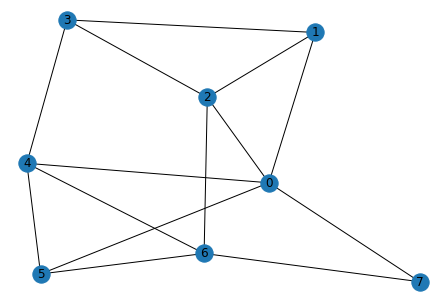

In [15]:
# generate a random graph
g = nx.newman_watts_strogatz_graph(8,3,0.7,seed=42)
# draw it with the default formatting
nx.draw(g, with_labels=True, pos=nx.kamada_kawai_layout(g), figsize=(4,3))

Words don't fit well inside the nodes, so one way I found that looks reasonable is:
1. Calculate the node positions using a [force-directed layout](https://en.wikipedia.org/wiki/Force-directed_graph_drawing)
2. Draw the nodes and edges using those positions
3. Nudge the positions up a little
4. Draw the node labels with the nudged positions

In [16]:
def extend_axes(ax, factor):
    '''
    Extends the x- and y-axes of a matplotlib.pyplot.Axes object by the specified factor
    '''
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    midx = sum(xlim)/2
    midy = sum(ylim)/2
    
    new_xlim = tuple((x-midx)*factor + midx for x in xlim)
    new_ylim = tuple((y-midy)*factor + midy for y in ylim)
    
    ax.set_xlim(new_xlim)
    ax.set_ylim(new_ylim)

In [17]:
def draw_doc(g, ax):
    # draw nodes smaller, black and slightly transparent
    opts = {'node_size':10, 'node_color':'k', 'alpha':0.7}
    
    # force-directed layout
    xy = nx.kamada_kawai_layout(g)
    
    # draw the nodes and edges
    nx.draw(g, pos=xy, ax=ax, **opts)
    
    # nudge positions upwards
    y = list(y for [x,y] in xy.values())
    yrange = max(y)-min(y)
    for k,v in xy.items(): v[1] += yrange/25
    
    # draw the labels with the nudged positions
    nx.draw_networkx_labels(g, pos=xy, ax=ax)
    
    # sometimes the labels don't quite fit
    # extend the plot dimensions a little
    extend_axes(ax, 1.1)

We run the `make_doc_graph` function defined above on the lesson spaCy document. I had to fine-tune the parameters to get an aesthetically-pleasing result on the graph.

In [18]:
lesson_text['graph'] = lesson_text.doc.map(lambda x:make_doc_graph(
    x, g_window=5, sg_topn=20, sg_window=50, sg_ngrams=1
))

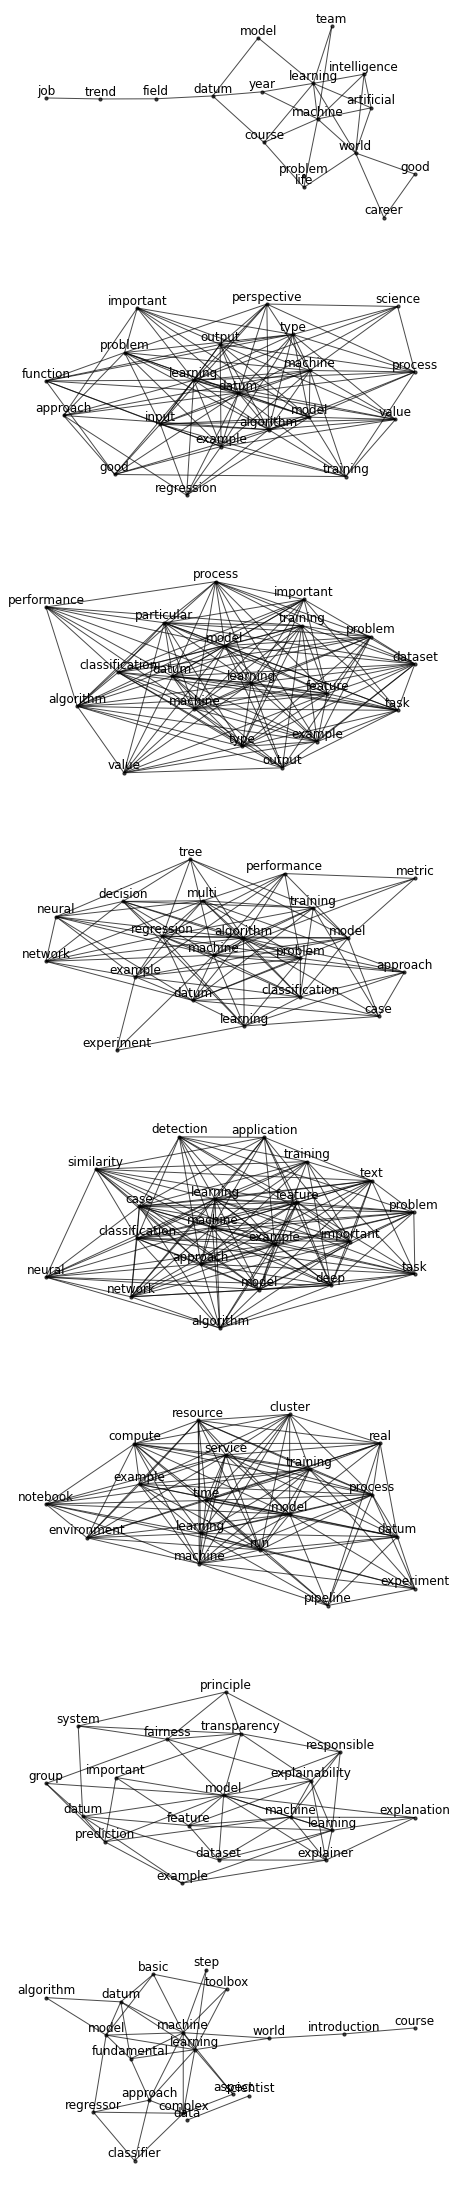

In [19]:
fig,ax = plt.subplots(nrows=8, ncols=1, figsize=(8,40))
for axi,g in zip(ax.ravel(),lesson_text.graph):
    draw_doc(g, axi)
plt.show()

## Thumbnail
Now that we have the wordclouds and lesson graphs, let's pick a thumbnail to go with the summary. I selected one video thumbnail out of all the videos in each lesson. Passing the video code to i.ytimg.com returns the thumbnail image.

In [20]:
lesson_text['thumb'] = ['C25mkY1R5Wc','BCl4VaChdPk','FyvqRyMoWRA','ZcuW7h8XPws','Lol7o0hihMU','oADXOnCXVNg','SPpEwlCFjvQ','Gqw9cHfuLcc']

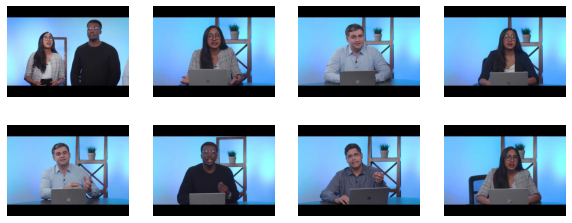

In [21]:
from skimage import io
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10,4))
for axi,thumb in zip(ax.ravel(),lesson_text.thumb):
    image_url=f'https://i.ytimg.com/vi/{thumb}/hqdefault.jpg'
    # download the thumbnail image and display it
    axi.imshow(io.imread(image_url))
    axi.axis('off')
plt.show()

## Putting it all together

We have all the components now for our lesson summary so let's compile them all into a single image.

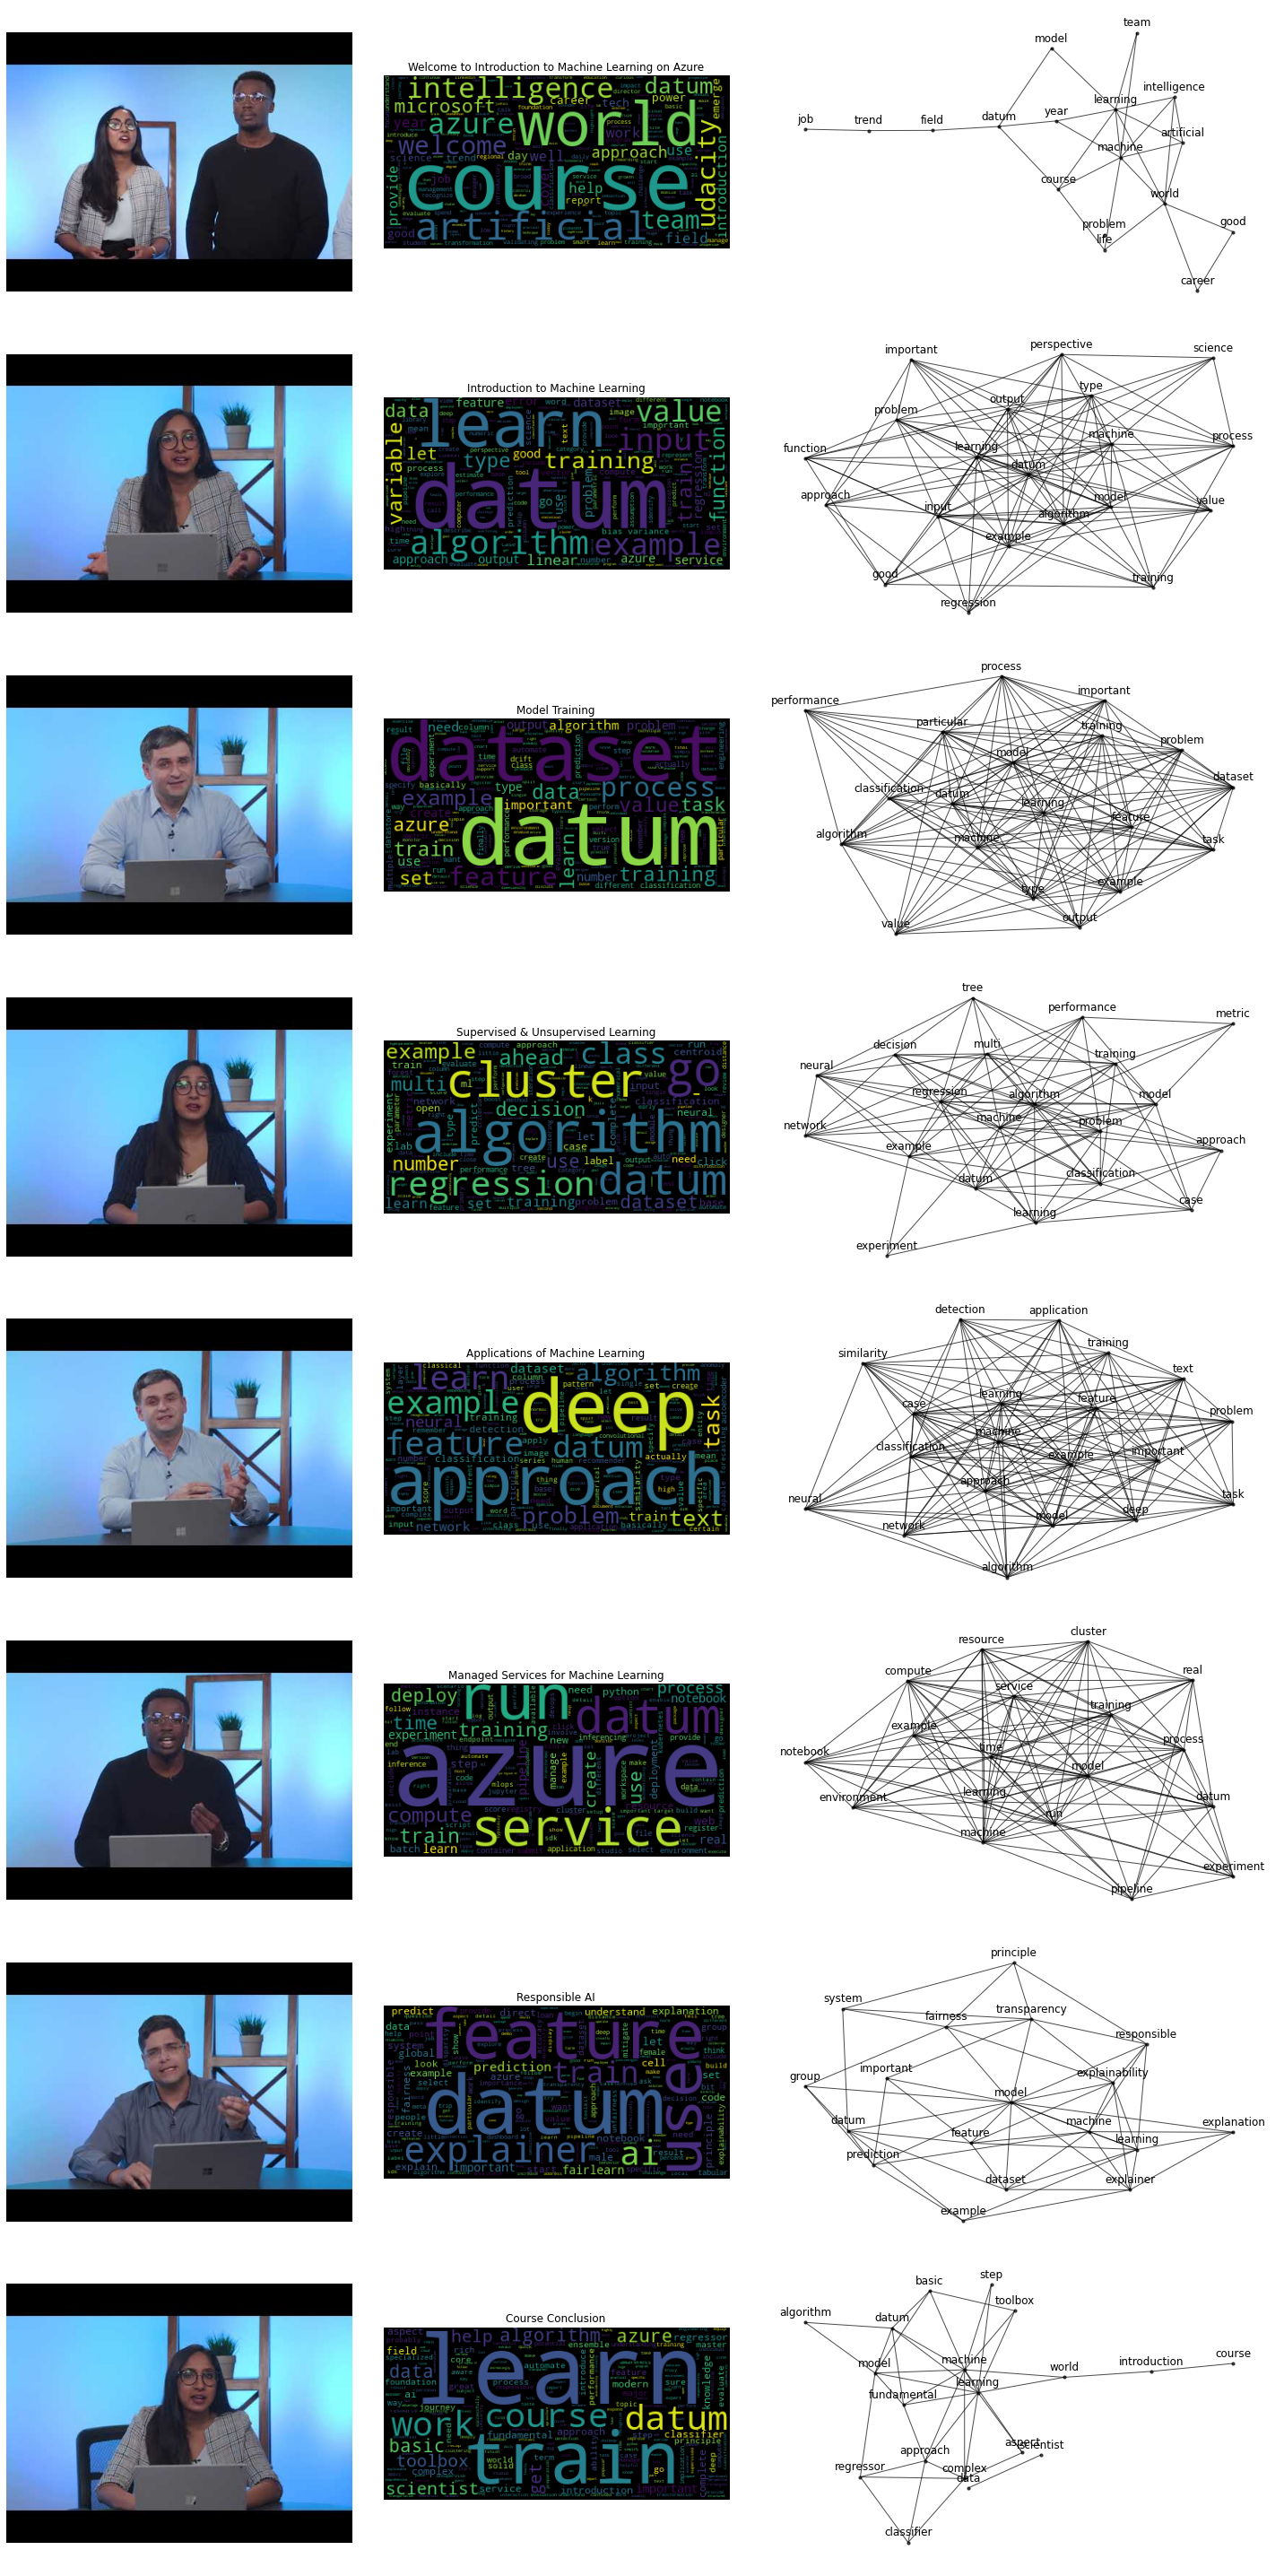

In [22]:
fig, ax = plt.subplots(nrows=8, ncols=3, figsize=(20,40), gridspec_kw={'width_ratios': [2,2,3]})
axx = ax.ravel()
for ax_thumb,ax_wc,ax_g,(_,(lesson,wcloud,g,thumb)) in zip(axx[::3],axx[1::3],axx[2::3],lesson_text[['lesson_name','cloud','graph','thumb']].iterrows()):
    image_url=f'https://i.ytimg.com/vi/{thumb}/hqdefault.jpg'
    ax_thumb.imshow(io.imread(image_url))
    ax_thumb.axis('off')
    ax_wc.imshow(wcloud)
    ax_wc.axis('off')
    ax_wc.set_title(lesson)
    draw_doc(g, ax_g)
plt.tight_layout()
plt.show()